# Welcome to Juno

This document is called Jupyter notebook. <i>Run</i> button will evaluate selected cell, and code output will appear in the cell output area below.

In [ ]:
# Give it a go:
print("Hello, world!")

## What is Jupyter notebook?

Jupyter is an interactive computing environment that works with <i>notebooks</i>, a document format that lets you store executable code, markdown text, plots, images and equations in LaTeX — all wrapped into a single notebook file (like the one you are viewing right now!). 

Notebooks consist of a sequence of <i>cells</i>, each representing either rich narrative text, or a snippet of executable code. Code output is embedded into the notebook, which makes it a complete and self-contained record of a computation in a human-readable form — and a perfect playground for data analysis and experiments!

## What is Juno?

Juno lets you view, edit and run Jupyter notebooks on iOS and iPadOS. It comes with a Python interpreter and  brings a lot of powerful <i>desktop</i> tools for data analysis and scientific computing to your mobile devices: it comes with NumPy, Matplotlib, Pandas, SciPy, Scikit-learn and other libraries. And if something is missing, you can easily install packages from Python Package Index — as long as they are in pure Python and don't have native extensions.

## Let's see how it works!

We will explore a sample dataset, and will then use it to build and train a classifier model based on a multi-layer neural network. All right on your device, without leaving this document!

We will use [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), which consists of 50 samples from each of three species of Iris (<i>Iris setosa</i>, <i>Iris virginica</i> and <i>Iris versicolor</i>). This dataset contains four features measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, we will develop a classifier to distinguish the species from each other. This is what they look like in real life:

<div>
    <div style="float:left;margin-right:15px;">
        <a href="https://en.wikipedia.org/wiki/File:Kosaciec_szczecinkowaty_Iris_setosa.jpg">
            <img src="welcome-data/assets/Iris_setosa.jpg" alt="Iris setosa" height="185" width="185"/>
        </a>
        <p style="text-align:center;font-size:0.85rem;">Iris setosa</p>
    </div>
    <div style="float:left;margin-right:15px;">
        <a href="https://en.wikipedia.org/wiki/Iris_versicolor#/media/File:Blue_Flag,_Ottawa.jpg">
            <img src="welcome-data/assets/Iris_versicolor.jpg" alt="Iris versicolor" height="185" width="185"/>
        </a>
        <p style="text-align:center;font-size:0.85rem;">Iris versicolor</p>
    </div>
    <div style="float:left;">
        <a href="https://en.wikipedia.org/wiki/Iris_virginica#/media/File:Iris_virginica_2.jpg">
            <img src="welcome-data/assets/Iris_virginica.jpg" alt="Iris virginica" height="185" width="185"/>
        </a>
        <p style="text-align:center;font-size:0.85rem;">Iris virginica</p>
    </div>
</div>

### Reading data

The dataset is stored in `iris.csv` file located in Juno's on-device storage, in `/Documents/data` folder — we will use Pandas module to read and inspect it. Keep in mind that it is usually much easier to work with relative paths on iOS and iPadOS. For example, this notebook is also located in Juno's `/Documents`, alongside `/data` directory. Notebook's cwd (working directory for executable code) is set to notebook's location by default — so we can read the data file using relative path `data/iris.csv`.

In [1]:
import pandas as pd

df = pd.read_csv("welcome-data/iris.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id                   150 non-null int64
Sepal length (cm)    150 non-null float64
Sepal width (cm)     150 non-null float64
Petal length (cm)    150 non-null float64
Petal width (cm)     150 non-null float64
Species              150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


Looks like the dataset consists of 150 samples, and has 6 columns: sample identifier, 4 measured features and sample label, i.e. the Iris species this sample belongs to. 

We will prepare a couple of convenience arrays, which will come handy later on:

In [2]:
# All unique Iris species from the data set
species = pd.unique(df['Species'].sort_values())
# Colors for identifying species on plots
colors = ['darkslateblue', 'turquoise', 'darkorange']
# List of measured features in the data set
features = ['Sepal length (cm)', 'Sepal width (cm)', 'Petal length (cm)', 'Petal width (cm)']
# Number of samples for each species
counts = df['Species'].value_counts().sort_index()

### Analyzing data

Let's see how sample data is distributed across classes using a bar plot with a number of samples for each Iris species in the dataset.

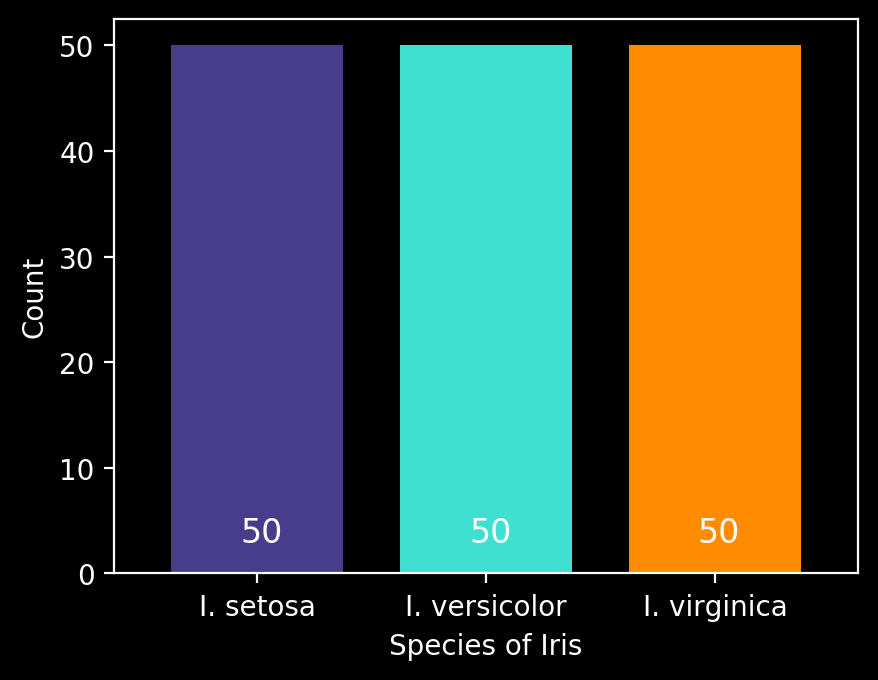

In [3]:
import matplotlib.pyplot as plt

# Display counts as bar plot
ax = counts.plot.bar(width=0.75, color=colors)
# Add counts as text over bars
for i, v in counts.reset_index().iterrows():
    ax.text(i - 0.075, 3.0, v.Species, color='white', size='large')
# Rotate X axis ticks
plt.xticks(rotation='horizontal')
# Add labels
plt.xlabel('Species of Iris')
plt.ylabel('Count')
plt.show()

Great, the dataset seems well-balanced — this means that we have the same number of samples for each class that we will be training our model to predict. If it wasn't (for example, if one of iris species had significantly more samples in the dataset than the others), we would need to do some extra work during pre-processing stage to make sure each class is equally represented: a classifier trained on imbalanced data can get biased, favoring the class with the largest proportion of samples, which may lead to misleading accuracies. But looks like we're good here!

Let's try to investigate if the features reported in the dataset will be helpful in separating samples into classes. We will start with a combination of 2D-projection scatter plots: there are 4 features in the dataset, which translates to 6 unique pairs of features to be used for 2D plot axes. You can think of each plot as a 2D projection of the "full" 4D feature space, which only takes 2 out of 4 available features into consideration.

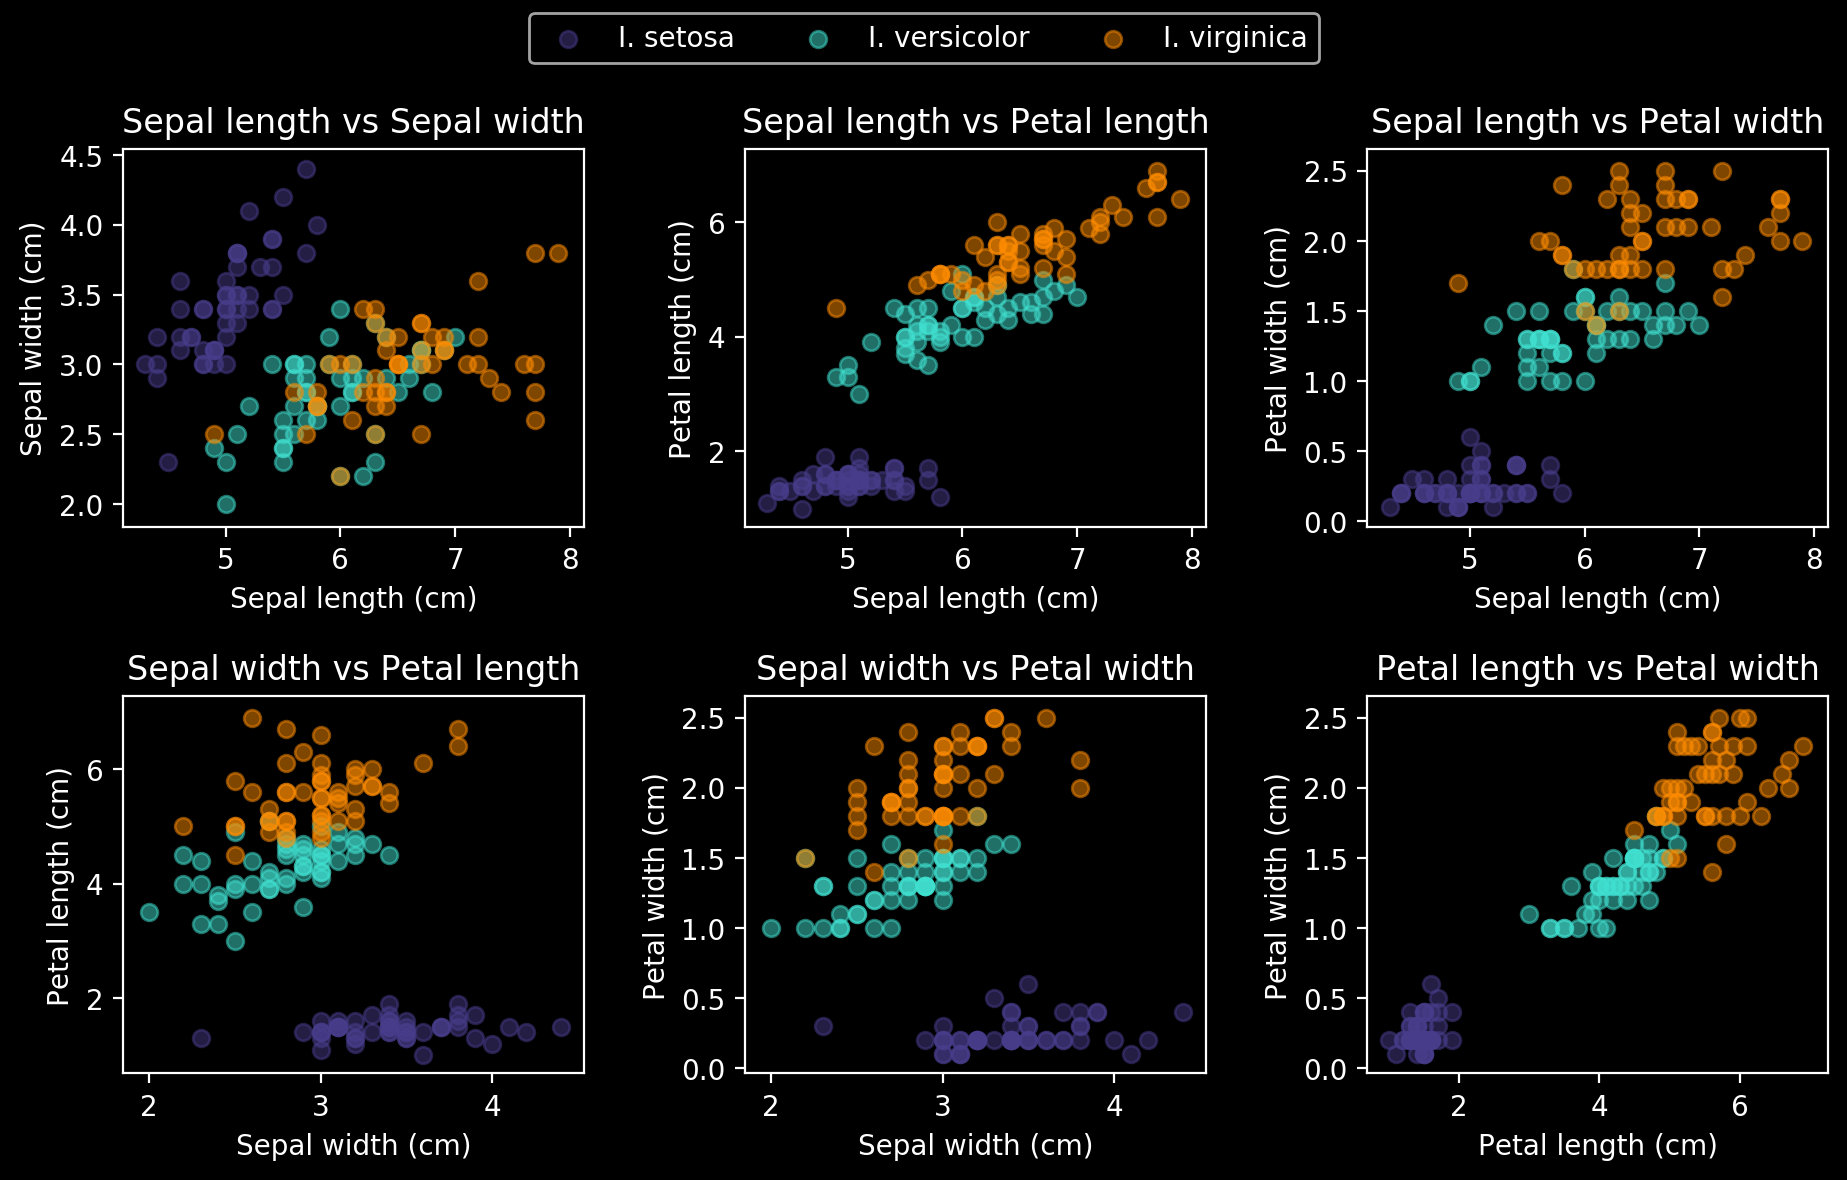

In [4]:
import numpy as np
import itertools

# Construct a list of 6 possible pairs of features
feature_2s = np.array(list(itertools.combinations(features, 2)))
# Plot each 2D projection
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 6))
plt.subplots_adjust(hspace=0.45, wspace=0.35)
for ax, feature1, feature2 in zip(axs.reshape(-1), feature_2s[:, 0], feature_2s[:, 1]):
    for name, color in zip(species, colors):    
        df_spec = df[df['Species'] == name]    
        ax.scatter(df_spec[feature1], df_spec[feature2], color=color, alpha=0.5, label=name)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title((feature1 + ' vs ' + feature2).replace(' (cm)',''))
# Add legend
handles, labels = axs[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.show()

Data samples seem to form fairly distinguishable blobs, and in some cases could even be linearly separable — great! It may be a bit more challenging to tell <i>Iris versicolor</i> from <i>Iris virginica</i> though. 

Let's take it one step further and try 3D-projection scatter plots: the idea is the same as before, but instead of 2D plots we will be plotting in 3D space. This reduces the number of combination of features to 4 (as we are now combining into triplets rather than pairs), therefore we will plot 4 figures.

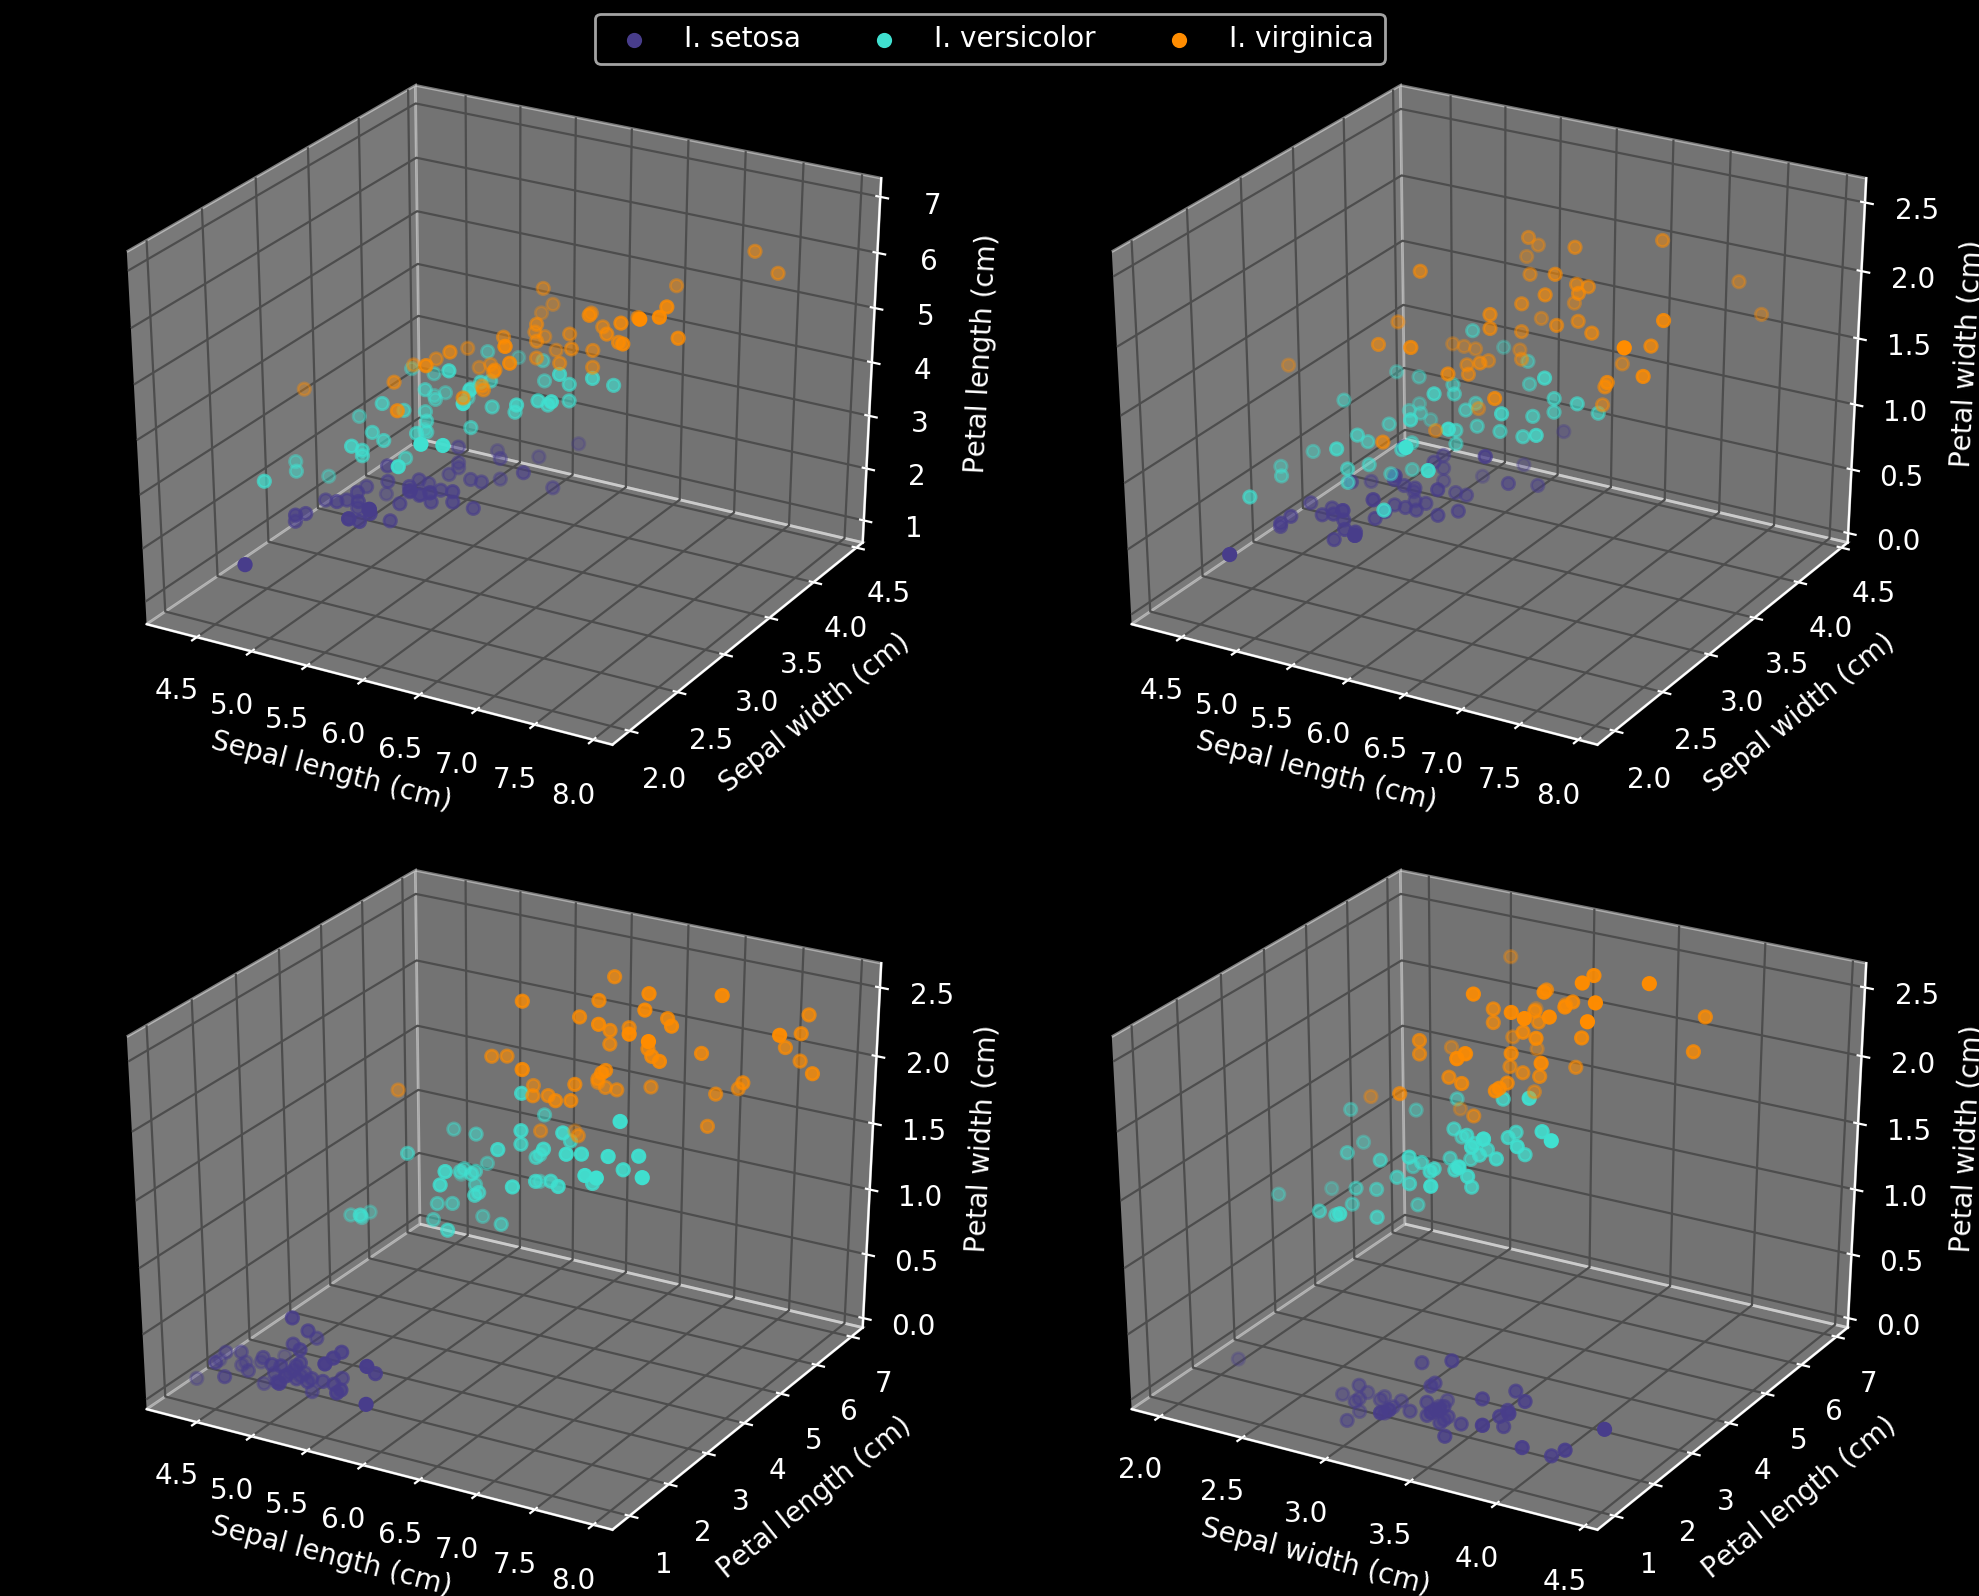

In [5]:
import itertools
from mpl_toolkits.mplot3d import Axes3D

# Construct a list of 4 possible triplets of features
feature_3s = np.array(list(itertools.combinations(features, 3)))
fig = plt.figure(figsize=(10, 8))
# Plot each 3D projection
for i in range(4):
    feature1 = feature_3s[i, 0]
    feature2 = feature_3s[i, 1]
    feature3 = feature_3s[i, 2]
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    for name, color in zip(species, colors):    
        df_spec = df[df['Species'] == name]    
        ax.scatter(df_spec[feature1], df_spec[feature2], df_spec[feature3], color=color, label=name)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(feature3)
# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

Looks like some features may be more helpful than the others, but in general there is no need for any advanced feature engineering techniques. We should be able to build a decent classifier by simply using all 4 features from the dataset.

### Data preprocessing

Although we will use all 4 features from the dataset, we do need to prepare the data first. Data preprocessing is a very important step of preparing (cleaning and organizing) raw collected data; its main objective is to make it easier for our classifier to extract meaningful insights from data during training. Let's start with features:

In [6]:
# Set float number formatting option for Pandas
pd.set_option('display.float_format', '{:.3f}'.format)
df[features].describe()

,Sepal length (cm),Sepal width (cm),Petal length (cm),Petal width (cm)
count,150.000,150.000,150.000,150.000
mean,5.843,3.054,3.759,1.199
std,0.828,0.434,1.764,0.763
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


All features in our dataset are continuous numeric values representing same measurement units, so we should be able to use them as is. The only thing worth doing is scaling, i.e. making sure all features have the properties of a standard normal distribution with a mean close to `0` and a standard deviation close to `1`, `sklearn.preprocessing.StandardScaler` will take care of that. 

In [7]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(df[features])
pd.DataFrame(data=X, columns=features).describe()

,Sepal length (cm),Sepal width (cm),Petal length (cm),Petal width (cm)
count,150.000,150.000,150.000,150.000
mean,-0.000,-0.000,0.000,0.000
std,1.003,1.003,1.003,1.003
min,-1.870,-2.439,-1.569,-1.444
25%,-0.901,-0.588,-1.228,-1.182
50%,-0.053,-0.125,0.336,0.133
75%,0.675,0.569,0.763,0.791
max,2.492,3.115,1.786,1.711


Looks much better! Intuitively, you can think of it like this: training a model usually involves minimizing a loss function — and loss function value depends on the raw input the model receives. Assuming you don't want a particular feature to contribute more to the loss value than the others, you would expect all features to stay within similar bounds. Otherwise, your model could make a false assumption that some features are more important than others, damaging the accuracy.

We also need to prepare labels, i.e. our target values — we will encode them using `sklearn.preprocessing.LabelEncoder`, which will simply translate strings with names of Iris species to numeric values.

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Species'])

Now `X` variable contains preprocessed features from our original dataset, and `y` contains corresponding labels. 

Finally, we will split our dataset into training and test sets. Training set will be used to train the classifier, and test set will let us evaluate model's accuracy after training is completed. We will collect model's predictions for samples from the test set (which classifier hasn't seen during training), and check how many of its predictions match the actual values.

In [9]:
from sklearn.model_selection import train_test_split

# Allocate 30% of original dataset to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Training a classifier

We will build a relatively simple classifier based on a neural network with two hidden layers using `sklearn.neural_network.MLPClassifier` (MLP standing for [multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)). First hidden layer will have 5 neurons, and second hidden layer will have 3 neurons, each followed by a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Model architecture will look like this:

<br>
<div align="center">
    <img src="welcome-data/assets/nn_light.png" class="juno_ui_theme_light" style="display: inline-block;" alt="MLP classifier architecture" width="600"><img src="welcome-data/assets/nn_dark.png" class="juno_ui_theme_dark" style="display: none; margin: 0px;" alt="MLP classifier architecture" width="600">
</div>

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

# Use stochastic gradient descent as optimization method
model = MLPClassifier(solver='sgd', max_iter=500, learning_rate_init=0.1, hidden_layer_sizes=(5, 3), random_state=42)
print('Training classifier on', y_train.size, 'examples...')
model.fit(X_train, y_train)
print('Training completed after', model.n_iter_, 'iterations with loss:', model.loss_)
print('Test set accuracy:', metrics.accuracy_score(model.predict(X_test), y_test))

Training classifier on 105 examples...
Training completed after 265 iterations with loss: 0.07634601000502604
Test set accuracy: 1.0


OK, looks good! You can re-run the training process on your device, and although exact loss value may be slightly different (due to network weights getting different initial random values), you should still get accuracy close to `1.0` (i.e. 100%) on the test set. Although it may seem unbelievably high, it shouldn't come as a surprise: Iris dataset is relatively small, and has fairly easily separable classes.

Now, let's check the learning curves to see how the training process went. It would be great to plot training loss against validation loss, but due to very limited size of the original data we didn't allocate any examples as a validation set. Let's check training loss:

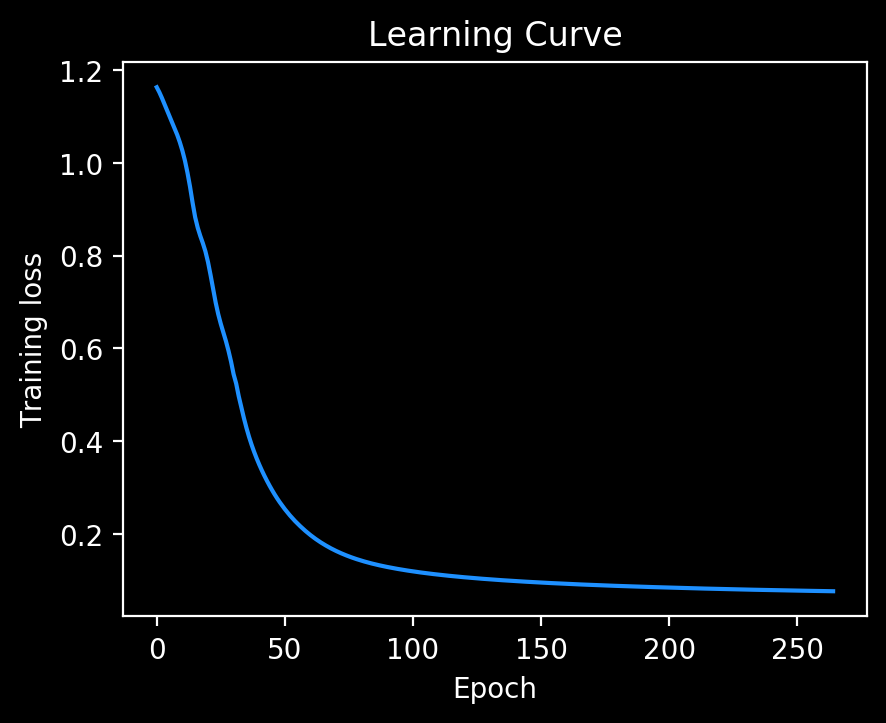

In [11]:
plt.plot(model.loss_curve_, color='dodgerblue')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Learning Curve')
plt.show()

Looks like training went fairly smooth — and loss could likely improve even further if we let it train longer. Although most likely the model would simply end up overfitting the training data, something that would be hard to identify and address without a validation set.

Finally, we can now use this classifier for arbitrary measurements! A very important point here is to make sure the values you feed into your classifier go through the same preprocessing steps that original dataset went through, using the same scaler object. If you have an iris flower at hand, feel free to use your own real-world measurements here:

In [12]:
sepal_length_cm = 5.5
sepal_width_cm = 2.9
petal_length_cm = 4.0
petal_width_cm = 1.4

# Scale features using the same scaler we used during preprocessing and get model prediction
prediction = model.predict(feature_scaler.transform([[sepal_length_cm, sepal_width_cm, petal_length_cm, petal_width_cm]]))
print('This appears to be a', label_encoder.inverse_transform(prediction)[0])

This appears to be a I. versicolor
